In [214]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer,assemble
from qiskit.quantum_info import Statevector

In [215]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results 
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        qc.barrier()
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit) 
        qc.measure_all()
            #no measurement at the end for the state_vector simulator
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    Returns: function
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(invert_counts(counts), graph)

    return execute_circ

In [216]:
def state_num2str(basis_state_as_num, nqubits):
    return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    new_str = basis_state_as_str[::-1]
    return state_str2num(new_str)

def get_adjusted_state(state):
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)

    adjusted_state = np.zeros(2**nqubits, dtype=complex)
    for basis_state in range(2**nqubits):
         adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [217]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts

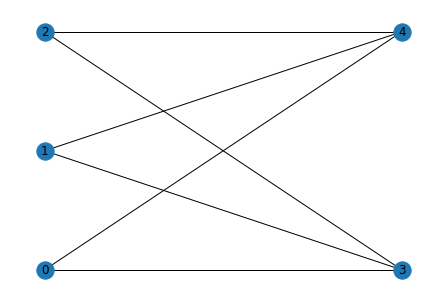

In [218]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G,with_labels = True, pos=nx.bipartite_layout(G, [0,1,2]))

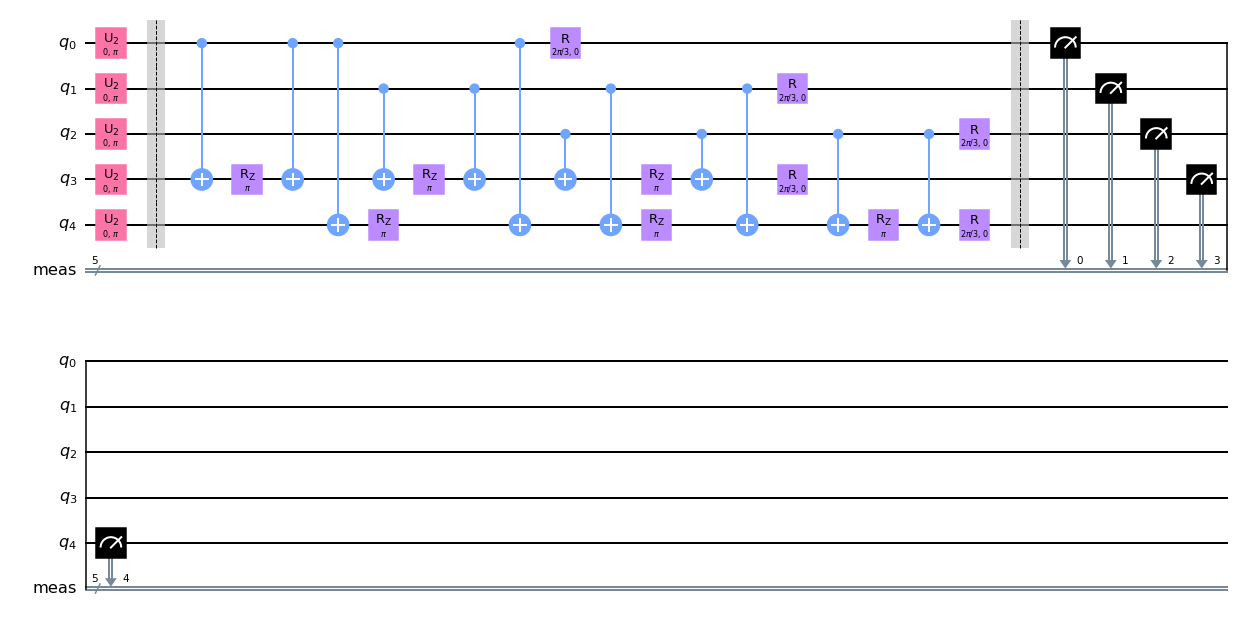

In [219]:
qc = create_qaoa_circ(G,[np.pi/3,np.pi/2])
qc.decompose().draw('mpl')

In [220]:
compute_expectation(invert_counts(result.get_counts()), G)

-6.0

In [221]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'11110': 35, '10010': 29, '10100': 27, '10001': 29, '01011': 34, '00100': 32, '00011': 37, '01000': 32, '10011': 28, '00000': 29, '10101': 41, '00111': 40, '01001': 38, '01100': 30, '10000': 34, '11001': 31, '01110': 31, '11100': 34, '11000': 31, '00010': 22, '00110': 35, '11111': 40, '11011': 30, '00001': 21, '10110': 34, '11101': 34, '00101': 32, '01010': 39, '10111': 36, '11010': 26, '01111': 30, '01101': 23}


In [222]:
p = 5 # Number of layers
expectation = get_expectation(G) #Cost function C(teta) of the entire circuit (training)
in_parameter_list = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ]) #We start setting some parameters
res = minimize(expectation,
               in_parameter_list,
               method='COBYLA',options={'maxiter':2500, 'disp': True})
res

     fun: -4.3623046875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 99
  status: 1
 success: True
       x: array([1.95195983, 2.25889703, 0.78616163, 2.16935638, 0.40124081,
       2.816261  , 6.12213505, 2.22215054, 3.81158214, 6.11103041])

   Normal return from subroutine COBYLA

   NFVALS =   99   F =-4.362305E+00    MAXCV = 0.000000E+00
   X = 1.951960E+00   2.258897E+00   7.861616E-01   2.169356E+00   4.012408E-01
       2.816261E+00   6.122135E+00   2.222151E+00   3.811582E+00   6.111030E+00


In [223]:
backend = Aer.get_backend('statevector_simulator')
qc = create_qaoa_circ(G, res.x)
result = execute(qc, backend).result()
sv = get_adjusted_state(result.get_statevector())
state_to_ampl_counts(sv)
Statevector(sv).draw('latex')

/tmp/ipykernel_6502/2539615542.py:13: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  nqubits = np.log2(state.shape[0])


<IPython.core.display.Latex object>

In [224]:
backend = Aer.get_backend('statevector_simulator')
qc = create_qaoa_circ(G, res.x)
result = execute(qc, backend).result()
sv = result.get_statevector()
state_to_ampl_counts(sv)

/tmp/ipykernel_6502/3501984869.py:5: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  qubit_dims = np.log2(vec.shape[0])
/tmp/ipykernel_6502/3501984869.py:11: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for kk in range(vec.shape[0]):


{'10001': (-0.12471678348268185+0.9921923825134589j)}

In [225]:
[1.0,1.0]

[1.0, 1.0]

In [226]:
Statevector([1.0,1.0])

Statevector([1.+0.j, 1.+0.j],
            dims=(2,))


In [227]:
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))

Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
